In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Bayesian optimization 

This notebook was made with the following version of george:

In [3]:
import george
george.__version__

'0.3.1'

In this tutorial, we'll show a very simple example of implementing "Bayesian optimization" using george.
Now's not the time to get into a discussion of the issues with the name given to these methods, but I think that the "Bayesian" part of the title comes from the fact that the method relies on the (prior) assumption that the objective function is smooth.
The basic idea is that you can reduce the number of function evaluations needed to minimize a black-box function by using a GP as a surrogate model.
This can be huge if evaluating your model is computationally expensive.
I think that the classic reference is [Jones et al. (1998)](https://doi.org/10.1023/A:1008306431147) and the example here will look a bit like their section 4.1.

First, we'll define the scalar objective that we want to minimize in the range $-5 \le x \le 5$.

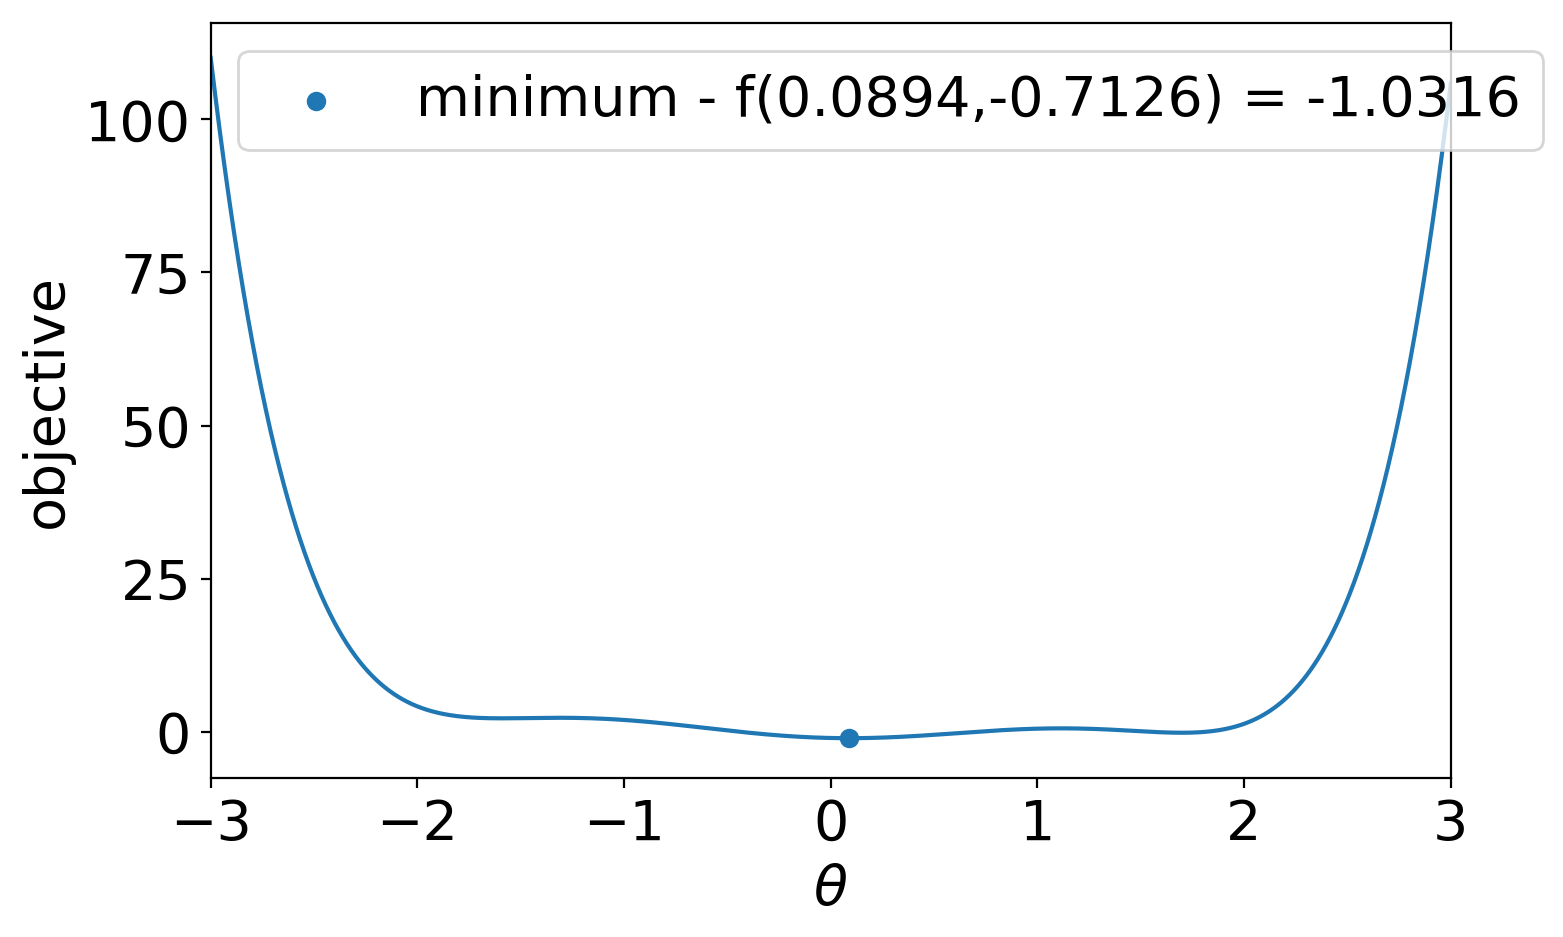

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def objective(theta):
    return -0.5 * np.exp(-0.5*(theta - 2)**2) - 0.5 * np.exp(-0.5 * (theta + 2.1)**2 / 5) + 0.3

def OneDCamel(t):
    x2 = -0.7126
    return (4 - 2.1*t**2 + (t**4)/3)* t**2 + t*x2 + (-4 + 4*x2**2)*x2**2

t = np.linspace(-3, 3, 5000)

plt.figure(figsize=(8, 5))
y = OneDCamel(t)
minPoint = np.argmin(y)
plt.plot(t, y)
label = "minimum - f({:.4f},{:.4}) = {:.4f}".format(t[minPoint], -0.7126, y[minPoint])
plt.scatter(t[minPoint],y[minPoint], label=label)
# plt.ylim(-0.37, 0.37)
plt.xlim(-3, 3)
plt.xlabel("$\\theta$")
plt.ylabel("objective")
plt.legend()

Now, for the "Bayesian" optimization, the basic procedure that we'll follow is:

1. Start by evaluating the model at a set of points. In this case, we'll start with a uniform grid in $x$.
2. Fit a GP (optimize the hyperparameters) to the set of training points.
3. Find the input coordinate that maximizes the "expected improvement" (see Section 4 of Jones+ 1998). For simplicity, we simply use a grid search to maximize this, but this should probably be a numerical optimization in any real application of this method.
4. At this new coordinate, run the model and add this as a new training point.
5. Return to step 2 until converged. We'll judge convergence using relative changes in the location of the minimum.

/Users/danielzeiberg/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/Users/danielzeiberg/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/Users/danielzeiberg/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/Users/danielzeiberg/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


9 model evaluations


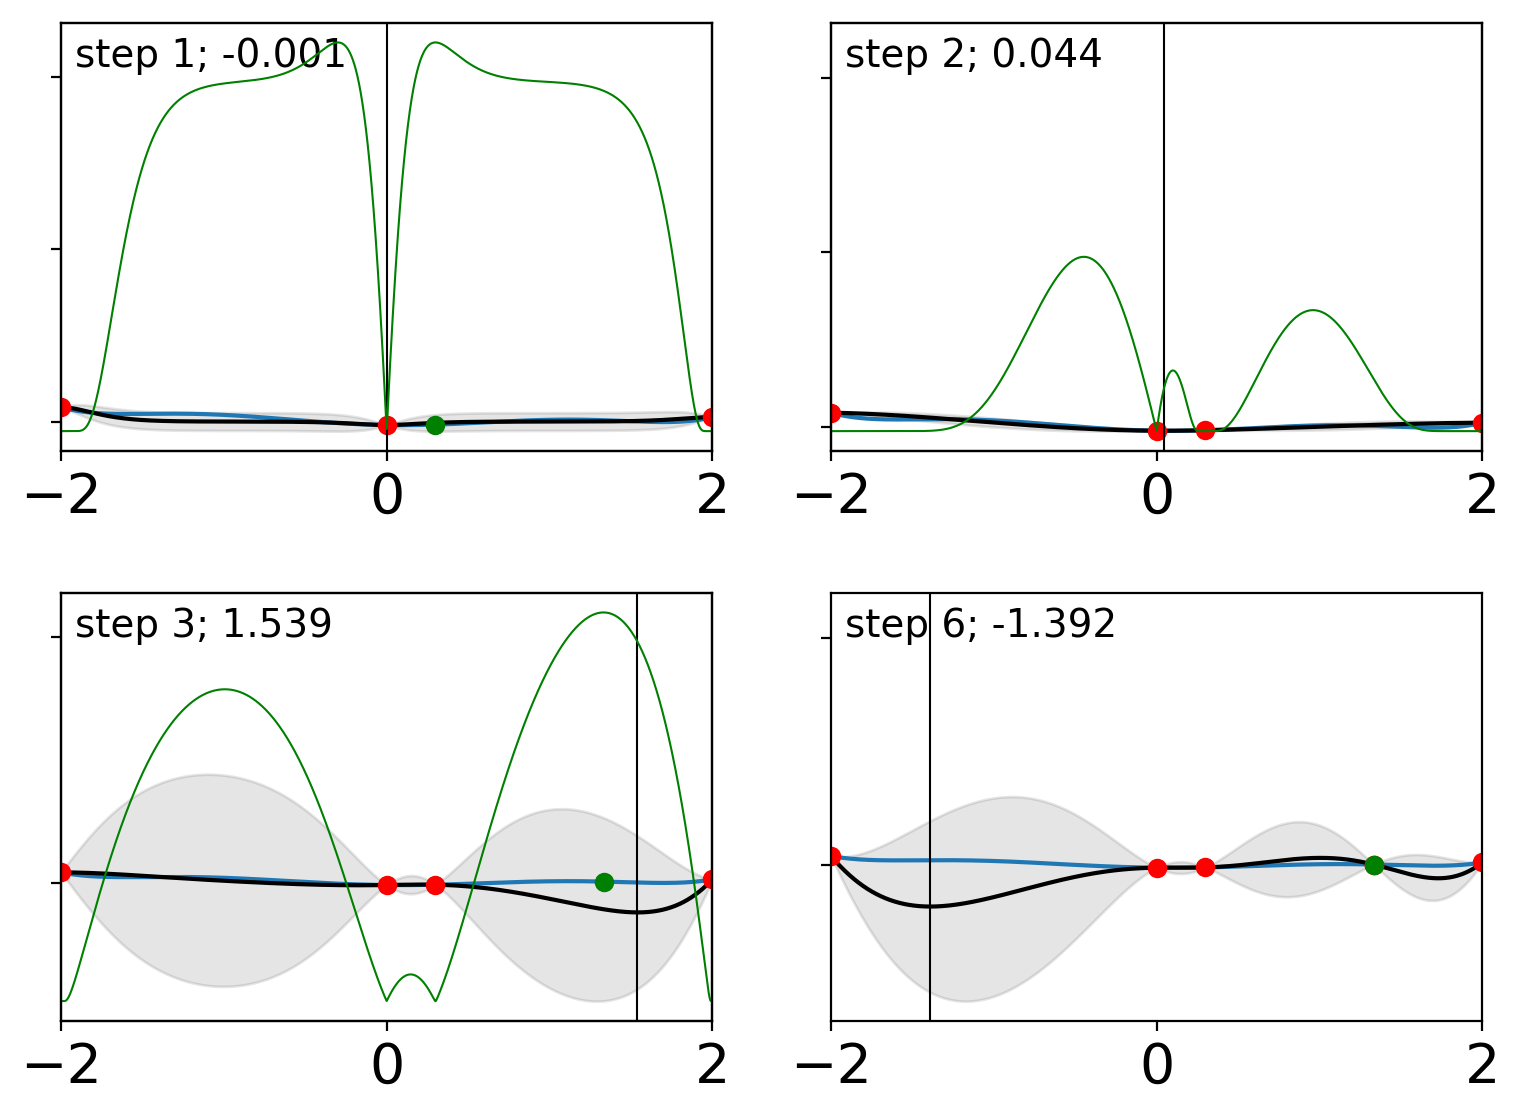

In [37]:
from george import kernels
from scipy.special import erf
from scipy.optimize import minimize

N_init = 3
train_theta = np.linspace(-3, 3, N_init + 1)[1:]
train_theta -= 0.5 * (train_theta[1] - train_theta[0])
train_f = OneDCamel(train_theta)

gp = george.GP(np.var(train_f) * kernels.Matern52Kernel(3.0),fit_mean=True)

gp.compute(train_theta)

def nll(params):
    gp.set_parameter_vector(params)
    g = gp.grad_log_likelihood(train_f, quiet=True)
    return -gp.log_likelihood(train_f, quiet=True), -g

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
j = 0
old_min = None
converged = False

for i in range(1000):
    # Update the GP parameters
    soln = minimize(nll, gp.get_parameter_vector(), jac=True)

    # Compute the acquisition function
    mu, var = gp.predict(train_f, t, return_var=True)
    std = np.sqrt(var)    
    f_min = np.min(train_f)
    chi = (f_min - mu) / std 
    Phi = 0.5 * (1.0 + erf(chi / np.sqrt(2)))
    phi = np.exp(-0.5 * chi**2) / np.sqrt(2*np.pi*var)
    A_ei = (f_min - mu) * Phi + var * phi
    A_max = t[np.argmax(A_ei)]

    # Add a new point
    train_theta = np.append(train_theta, A_max)
    train_f = np.append(train_f, OneDCamel(train_theta[-1]))
    gp.compute(train_theta)
    
    # Estimate the minimum - I'm sure that there's a better way!
    i_min = np.argmin(mu)
    sl = slice(max(0, i_min - 1), min(len(t), i_min + 2))
    ts = t[sl]
    D = np.vander(np.arange(len(ts)).astype(float))
    w = np.linalg.solve(D, mu[sl])
    minimum = ts[0] + (ts[1] - ts[0]) * np.roots(np.polyder(w[::-1]))
    
    # Check convergence
    if i > 0 and np.abs((old_min - minimum) / minimum) < 1e-5:
        converged = True
    old_min = float(minimum[0])
    
    # Make the plots
    if converged or i in [0, 1, 2]:
        ax = axes.flat[j]
        j += 1
        ax.plot(t, OneDCamel(t))
        ax.plot(t, mu, "k")
        ax.plot(train_theta[:-1], train_f[:-1], "or")
        ax.plot(train_theta[-1], train_f[-1], "og")
        ax.fill_between(t, mu+std, mu-std, color="k", alpha=0.1)
        if i <= 3:
            ax2 = ax.twinx()
            ax2.plot(t, A_ei, "g", lw=0.75)
            ax2.set_yticks([])
        ax.axvline(old_min, color="k", lw=0.75)
        #ax.set_ylim(-0.37, 0.37)
        ax.set_xlim(-2, 2)
        ax.set_yticklabels([])
        ax.annotate("step {0}; {1:.3f}".format(i+1, old_min), xy=(0, 1),
                    xycoords="axes fraction", ha="left", va="top",
                    xytext=(5, -5), textcoords="offset points",
                    fontsize=14)
    
    if converged:
        break

plt.tight_layout()

print("{0} model evaluations".format(len(train_f)))

There's a lot going on in these plots.
Each panel shows the results after a certain iteration (indicated in the top left corner of the panel).
In each panel:

1. The blue line is the true objective function.
2. The black line and gray contours indicate the current estimate of the objective using the GP model.
3. The green line is the expected improvement.
4. The red points are the training set.
5. The green point is the new point that was added at this step.
6. The vertical black line is the current estimate of the location minimum. This is also indicated in the top left corner of the panel.

As you can see, only 10 model evaluations (including the original training set) were needed to converge to the correct minimum.
In this simple example, there are certainly other methods that could have easily been used to minimize this function, but you can imagine that this method could be useful for cases where `objective` is very expensive to compute.